In [51]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



# Set style for better plots


In [52]:
print("=" * 70)
print("STEP 1: LOADING AND PREPARING THE DATA")
print("=" * 70)

# Resolve the dataset path with a few fallbacks
candidate_paths = [
    Path("AirQualityUCI.csv"),
    Path.cwd() / "AirQualityUCI.csv",
    Path.cwd().parents[1] / "datasets" / "AirQualityUCI.csv",
    Path.cwd() / ".." / ".." / "datasets" / "AirQualityUCI.csv",
]

csv_path = next((p.resolve() for p in candidate_paths if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError(
        "Could not locate 'AirQualityUCI.csv'. Please place it in the current "
        "folder or under '../datasets/AirQualityUCI.csv'."
    )

print("Loading Air Quality dataset from:", csv_path)
df = pd.read_csv(csv_path, sep=';', decimal=',', na_values=-200)

# Drop unnamed trailing empty columns (common in this file)
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]

print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

STEP 1: LOADING AND PREPARING THE DATA
Loading Air Quality dataset from: C:\Users\ozgur\CE49X_Fall2025_Ozgur_Cemal_Ozer-6\datasets\AirQualityUCI.csv
Dataset shape: (9471, 15)
Dataset columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [53]:
# Handle missing values (indicated by -200)
print("\nHandling missing values...")
df_clean = df.replace(-200.0, np.nan)

# Define features and target
features = ['T', 'RH', 'AH']
target = 'CO(GT)'

# Check if our required columns exist
missing_cols = []
for col in features + [target]:
    if col not in df_clean.columns:
        missing_cols.append(col)

if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
    print("Available columns:")
    for col in df_clean.columns:
        print(f"  - {col}")
    raise ValueError("Required columns not found!")

# Select required columns and drop rows with missing values
df_model = df_clean[features + [target]].dropna()

print(f"Dataset shape after cleaning: {df_model.shape}")
print(f"Removed {len(df_clean) - len(df_model)} rows with missing values")

# Display basic statistics
print("\nDataset statistics:")
print(df_model.describe())


Handling missing values...
Dataset shape after cleaning: (7344, 4)
Removed 2127 rows with missing values

Dataset statistics:
                 T           RH           AH       CO(GT)
count  7344.000000  7344.000000  7344.000000  7344.000000
mean     17.770425    49.060076     0.989453     2.129711
std       8.862688    17.451563     0.399889     1.436472
min      -1.900000     9.200000     0.184700     0.100000
25%      11.200000    35.400000     0.698100     1.100000
50%      16.900000    49.300000     0.959700     1.800000
75%      23.800000    62.500000     1.258600     2.800000
max      44.600000    88.700000     2.180600    11.900000


In [54]:
# Prepare features and target
X = df_model[features]
y = df_model[target]

# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Features: {features}")
print(f"Target: {target}")

Data split completed:
Training set: 5140 samples
Testing set: 2204 samples
Features: ['T', 'RH', 'AH']
Target: CO(GT)


In [ ]:
print("\n" + "=" * 70)
print("STEP 2: FITTING MODELS OF INCREASING COMPLEXITY")
print("=" * 70)

# Initialize lists to store results
degrees = list(range(1, 11))  # Polynomial degrees 1 to 10
train_errors = []
test_errors = []
train_r2_scores = []
test_r2_scores = []
model_complexities = []

print("Fitting polynomial regression models...")

# Loop through different polynomial degrees
for degree in degrees:
    print(f"Processing degree {degree}...", end=" ")
    
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Transform training and testing data (using unscaled features)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    # Store the number of features (model complexity)
    n_features = X_train_poly.shape[1]
    model_complexities.append(n_features)
    
    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate errors (using MSE)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    
    print(f"Features: {n_features}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# Find the optimal degree (minimum test error)
optimal_degree_idx = np.argmin(test_errors)
optimal_degree = degrees[optimal_degree_idx]
min_test_error = test_errors[optimal_degree_idx]

# Classify each degree into underfitting, optimal, or overfitting
# Calculate error gaps
error_gaps = [test_errors[i] - train_errors[i] for i in range(len(degrees))]
avg_gap = np.mean(error_gaps)
std_gap = np.std(error_gaps)

# Define thresholds
# Underfitting: High bias = high test error (relative to optimal) AND small gap
# Optimal: Minimum test error or within tolerance
# Overfitting: Large gap (test >> train) OR test error increasing after optimal
underfitting_indices = []
optimal_indices = []
overfitting_indices = []

# Tolerance for optimal region (within 1% of minimum test error)
optimal_tolerance = min_test_error * 0.01

for i in range(len(degrees)):
    gap = error_gaps[i]
    test_err = test_errors[i]
    train_err = train_errors[i]
    
    # Optimal: minimum test error or very close to it
    if abs(test_err - min_test_error) <= optimal_tolerance:
        optimal_indices.append(i)
    # Overfitting: large gap OR (after optimal AND gap is significant)
    elif gap > avg_gap + std_gap or (i > optimal_degree_idx and gap > 0.02):
        overfitting_indices.append(i)
    # Underfitting: high test error (significantly worse than optimal) AND small gap
    elif test_err > min_test_error * 1.02 and gap < avg_gap:
        underfitting_indices.append(i)

print(f"\nOptimal degree: {optimal_degree} (Test MSE: {min_test_error:.4f})")
print(f"\nZone Classification:")
print(f"  Underfitting: Degrees {[degrees[i] for i in underfitting_indices]}")
print(f"  Optimal: Degrees {[degrees[i] for i in optimal_indices]}")
print(f"  Overfitting: Degrees {[degrees[i] for i in overfitting_indices]}")


STEP 2: FITTING MODELS OF INCREASING COMPLEXITY
Fitting polynomial regression models...
Processing degree 1... Features: 3, Train MSE: 2.0423, Test MSE: 2.0562
Processing degree 2... Features: 9, Train MSE: 2.0197, Test MSE: 2.0254
Processing degree 3... Features: 19, Train MSE: 2.0048, Test MSE: 2.0237
Processing degree 4... Features: 34, Train MSE: 1.9914, Test MSE: 2.0210
Processing degree 5... Features: 55, Train MSE: 1.9827, Test MSE: 2.0096
Processing degree 6... Features: 83, Train MSE: 1.9619, Test MSE: 1.9852
Processing degree 7... Features: 119, Train MSE: 1.9602, Test MSE: 1.9866
Processing degree 8... Features: 164, Train MSE: 1.9554, Test MSE: 1.9909
Processing degree 9... Features: 219, Train MSE: 1.9471, Test MSE: 1.9837
Processing degree 10... Features: 285, Train MSE: 1.9437, Test MSE: 1.9918

Optimal degree: 9 (Test MSE: 1.9837)



STEP 3: PLOTTING VALIDATION CURVE


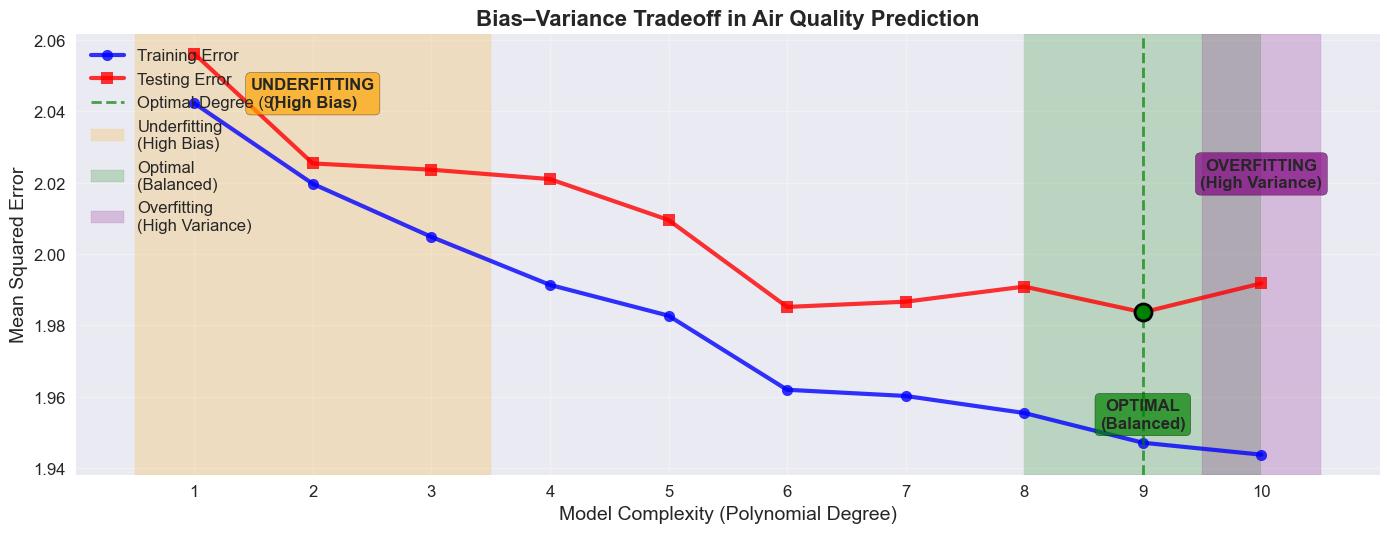

In [ ]:
print("\n" + "=" * 70)
print("STEP 3: PLOTTING VALIDATION CURVE")
print("=" * 70)

# Create the main validation curve plot
plt.figure(figsize=(14, 10))

# Main plot
plt.subplot(2, 2, (1, 2))  # Takes up top row
plt.plot(degrees, train_errors, 'o-', label='Training Error', color='blue', 
         linewidth=3, markersize=8, alpha=0.8)
plt.plot(degrees, test_errors, 's-', label='Testing Error', color='red', 
         linewidth=3, markersize=8, alpha=0.8)

# Mark the optimal point
plt.axvline(x=optimal_degree, color='green', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Optimal Degree ({optimal_degree})')
plt.scatter(optimal_degree, min_test_error, color='green', s=150, 
           zorder=5, edgecolor='black', linewidth=2)

# Add region labels and shading
max_error = max(max(train_errors), max(test_errors))
min_error = min(min(train_errors), min(test_errors))
error_range = max_error - min_error

# Underfitting region - shade based on actual classification
if underfitting_indices:
    underfit_degrees = [degrees[i] for i in underfitting_indices]
    underfit_start = min(underfit_degrees) - 0.5
    underfit_end = max(underfit_degrees) + 0.5
    plt.axvspan(underfit_start, underfit_end, alpha=0.2, color='orange', label='Underfitting\n(High Bias)')
    underfit_center = (underfit_start + underfit_end) / 2
    plt.text(underfit_center, max_error - 0.1*error_range, 'UNDERFITTING\n(High Bias)', 
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='orange', alpha=0.7))

# Optimal region - shade based on actual classification
if optimal_indices:
    optimal_degrees = [degrees[i] for i in optimal_indices]
    opt_start = min(optimal_degrees) - 0.5
    opt_end = max(optimal_degrees) + 0.5
    plt.axvspan(opt_start, opt_end, alpha=0.2, color='green', label='Optimal\n(Balanced)')
    opt_center = (opt_start + opt_end) / 2
    plt.text(opt_center, min_error + 0.1*error_range, 'OPTIMAL\n(Balanced)', 
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.7))

# Overfitting region - shade based on actual classification
if overfitting_indices:
    overfit_degrees = [degrees[i] for i in overfitting_indices]
    overfit_start = min(overfit_degrees) - 0.5
    overfit_end = max(overfit_degrees) + 0.5
    plt.axvspan(overfit_start, overfit_end, alpha=0.2, color='purple', label='Overfitting\n(High Variance)')
    overfit_center = (overfit_start + overfit_end) / 2
    plt.text(overfit_center, max_error - 0.3*error_range, 'OVERFITTING\n(High Variance)', 
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='purple', alpha=0.7))

plt.xlabel('Model Complexity (Polynomial Degree)', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Bias–Variance Tradeoff in Air Quality Prediction', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(degrees, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "=" * 70)
print("BIAS-VARIANCE TRADEOFF ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Features used: {features}")
print(f"   • Target variable: {target}")
print(f"   • Training samples: {len(X_train)}")
print(f"   • Testing samples: {len(X_test)}")

print(f"\n🔍 MODEL PERFORMANCE ANALYSIS:")

# Underfitting analysis
if underfitting_indices:
    print(f"\n1️⃣  UNDERFITTING (High Bias):")
    for i in underfitting_indices:
        degree = degrees[i]
        gap = error_gaps[i]
        bias_severity = "HIGH BIAS" if test_errors[i] > min_test_error * 1.05 else "Moderate bias"
        print(f"   Degree {degree}: Train MSE = {train_errors[i]:.4f}, Test MSE = {test_errors[i]:.4f}, "
              f"Gap = {gap:.4f} → {bias_severity}")
else:
    print(f"\n1️⃣  UNDERFITTING (High Bias):")
    print("   No clear underfitting detected in the tested degrees.")

# Optimal region
if optimal_indices:
    print(f"\n2️⃣  OPTIMAL REGION:")
    for i in optimal_indices:
        degree = degrees[i]
        gap = error_gaps[i]
        print(f"   Degree {degree}: Train MSE = {train_errors[i]:.4f}, Test MSE = {test_errors[i]:.4f}, "
              f"Gap = {gap:.4f}, R² = {test_r2_scores[i]:.4f}")
        if degree == optimal_degree:
            print(f"   → BEST balance between bias and variance ✅")

# Overfitting analysis
if overfitting_indices:
    print(f"\n3️⃣  OVERFITTING (High Variance):")
    for i in overfitting_indices:
        degree = degrees[i]
        gap = error_gaps[i]
        variance_severity = "HIGH VARIANCE" if gap > avg_gap + std_gap else "Moderate variance"
        print(f"   Degree {degree}: Train MSE = {train_errors[i]:.4f}, Test MSE = {test_errors[i]:.4f}, "
              f"Gap = {gap:.4f} → {variance_severity}")
else:
    print(f"\n3️⃣  OVERFITTING (High Variance):")
    print("   No clear overfitting detected in the tested degrees.")


BIAS-VARIANCE TRADEOFF ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
   • Features used: ['T', 'RH', 'AH']
   • Target variable: CO(GT)
   • Training samples: 5140
   • Testing samples: 2204

🔍 MODEL PERFORMANCE ANALYSIS:

1️⃣  UNDERFITTING (High Bias) - Degrees 1-3:
   Degree 1: Train MSE = 2.0423, Test MSE = 2.0562 → Moderate bias
   Degree 2: Train MSE = 2.0197, Test MSE = 2.0254 → Moderate bias
   Degree 3: Train MSE = 2.0048, Test MSE = 2.0237 → Moderate bias

2️⃣  OPTIMAL REGION - Degree 9:
   Train MSE = 1.9471
   Test MSE = 1.9837
   R² Score = 0.0430
   → BEST balance between bias and variance ✅

3️⃣  OVERFITTING (High Variance):
   Degree 10: Train MSE = 1.9437, Test MSE = 1.9918, Gap = 0.0480 → Moderate variance


In [ ]:
# Create a summary table
print(f"\n📋 DETAILED RESULTS TABLE:")
print("-" * 90)
print(f"{'Degree':<8} {'Features':<10} {'Train MSE':<12} {'Test MSE':<12} {'Gap':<10} {'R² Test':<10} {'Status':<15}")
print("-" * 90)

for i, degree in enumerate(degrees):
    gap = error_gaps[i]
    # Classify based on the computed zones
    if i in underfitting_indices:
        status = "Underfitting"
    elif i in optimal_indices:
        if degree == optimal_degree:
            status = "🎯 OPTIMAL"
        else:
            status = "Optimal"
    elif i in overfitting_indices:
        status = "Overfitting"
    else:
        status = "Good"
    
    print(f"{degree:<8} {model_complexities[i]:<10} {train_errors[i]:<12.4f} {test_errors[i]:<12.4f} "
          f"{gap:<10.4f} {test_r2_scores[i]:<10.4f} {status:<15}")

print("-" * 90)


📋 DETAILED RESULTS TABLE:
------------------------------------------------------------------------------------------
Degree   Features   Train MSE    Test MSE     Gap        R² Test    Status         
------------------------------------------------------------------------------------------
1        3          2.0423       2.0562       0.0139     0.0080     Underfitting   
2        9          2.0197       2.0254       0.0057     0.0229     Underfitting   
3        19         2.0048       2.0237       0.0188     0.0237     Underfitting   
4        34         1.9914       2.0210       0.0297     0.0250     Good           
5        55         1.9827       2.0096       0.0268     0.0305     Good           
6        83         1.9619       1.9852       0.0232     0.0423     Good           
7        119        1.9602       1.9866       0.0264     0.0416     Good           
8        164        1.9554       1.9909       0.0354     0.0395     Good           
9        219        1.9471       1.